In [473]:
import pandas as pd
from datetime import datetime
import datetime as dt
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import statsmodels.api as sm


In [474]:
raw1 = pd.read_csv('Raw_1.csv')
raw2 = pd.read_csv('Raw_2.csv')

## Data Processing
### Merge Raw_1 and Raw_2

In [475]:
merge = raw1.merge(raw2,on = 'ID',how = 'left')
merge['Address'] = merge['Address'].apply(lambda x:'NA' if pd.isnull(x) else x)
merge['StartTime']= [datetime.strptime(str(x),'%H:%M:%S').time() for x in merge['StartTime']]

### Compute the service time

In [476]:
D1 = []
for i in range(1,382):
    diff_1 = merge[merge['Session']==i][['StartTime']][1:].reset_index(drop  = True)
    diff_1['StartTime'] = diff_1['StartTime'].apply(lambda x :datetime.combine(dt.date.today(),x))
    diff_2 = merge[merge['Session']==i][['StartTime']][:-1].reset_index(drop  = True)
    diff_2['StartTime'] = diff_2['StartTime'].apply(lambda x :datetime.combine(dt.date.today(),x))
    diff = (diff_1-diff_2)['StartTime'].to_list()
    diff.append(pd.NA)
    #print(diff)
    D1.extend(diff)


In [477]:
diff_1 = merge['StartTime'].apply(lambda x :datetime.combine(dt.date.today(),x) if pd.notnull(x) else x)
diff_2 = merge['PayTime'].apply(
    lambda x :datetime.combine(dt.date.today(),datetime.strptime(str(x),'%H:%M:%S').time()) if pd.notnull(x) else x)
D2 = (diff_2-diff_1).to_list()

In [478]:
duration =pd.DataFrame({'D1':D1,
                        'D2':D2})
duration['servicetime'] = 0
for i in range(len(duration)):
    if pd.isnull(duration['D1'][i]):
        duration.loc[i,'servicetime']=duration['D2'][i]
        continue
    if pd.isnull(duration['D2'][i]):
        duration.loc[i,'servicetime']=duration['D1'][i]
        continue
    duration.loc[i,'servicetime'] = min(duration['D1'][i],duration['D2'][i])

In [479]:
duration['servicetime'] = duration['servicetime'].apply(lambda x : dt.timedelta.total_seconds(x) if pd.notnull(x) else pd.NA)
merge['ServTime']= duration['servicetime']
merge['ServTime'] = merge['ServTime'].astype('Int64')

### Filter data

In [480]:
Data=merge[(merge['ServTime']<=3600) & (merge['ServTime']>=180) & (merge['Visit.No'].notnull())]
Data.to_csv('Data.csv')
merge['ServTime'] = merge['ServTime'].apply(lambda x: x if pd.notnull(x) else 'NA')
merge.to_csv('Merged_ServiceTime.csv')


In [481]:
Data = Data.assign(ServTime=lambda d: d['ServTime'].astype(float))

## Exploratory Data Analysis

In [482]:
#Number of consultations per session
print(Data.groupby('Session')['ID'].count().mean())
print(Data.groupby('Session')['ID'].count().median())
print(Data.groupby('Session')['ID'].count().max())
print(Data.groupby('Session')['ID'].count().min())


17.41994750656168
18.0
32
4


In [483]:
#Number of sessions per day-of-week
Data.drop_duplicates('Session').groupby('DayOfWeek')['ID'].count()

DayOfWeek
Friday        10
Saturday     188
Tuesday        6
Wednesday    177
Name: ID, dtype: int64

In [484]:
#number of sessions on working vs. non-working days
Data.drop_duplicates('Session').groupby('WorkingDay')['ID'].count()

WorkingDay
False    178
True     203
Name: ID, dtype: int64

In [485]:
#Number of morning- vs. afternoon-sessions
Data.drop_duplicates('Session').groupby('AM_PM')['ID'].count()

AM_PM
afternoon    190
morning      191
Name: ID, dtype: int64

In [486]:
#Number of consultations grouped by ‘Gender'
Data.groupby('Gender')['ID'].count()

Gender
F    3943
M    2694
Name: ID, dtype: int64

In [487]:
#Number of consultations grouped by ‘M.Cancer'
Data.groupby('M.Cancer')['ID'].count()

M.Cancer
False    6017
True      620
Name: ID, dtype: int64

In [488]:
#Number of consultations grouped by ‘S.Cancer’
Data.groupby('S.Cancer')['ID'].count()

S.Cancer
False    6570
True       67
Name: ID, dtype: int64

In [489]:
#Number of consultations grouped by ‘Gender’ and Cancer Conditions
pd.pivot_table(Data,index = 'M.Cancer',columns='Gender',values='ID',aggfunc=['count'])

count      
Gender       F     M
M.Cancer            
False     3586  2431
True       357   263

In [490]:
#Number of consultations grouped by ‘Gender’ and Cancer Conditions
pd.pivot_table(Data,index = 'S.Cancer',columns='Gender',values='ID',aggfunc=['count'])

count      
Gender       F     M
S.Cancer            
False     3885  2685
True        58     9

In [491]:
Data.describe()

,Session,Visit.No,ServTime
count,6637.000000,6637.000000,6637.000000
mean,193.669429,6.830646,801.910954
std,111.089056,15.588881,372.913355
min,1.000000,1.000000,180.000000
25%,96.000000,1.000000,540.000000
50%,194.000000,2.000000,725.000000
75%,292.000000,6.000000,975.000000
max,381.000000,170.000000,3457.000000


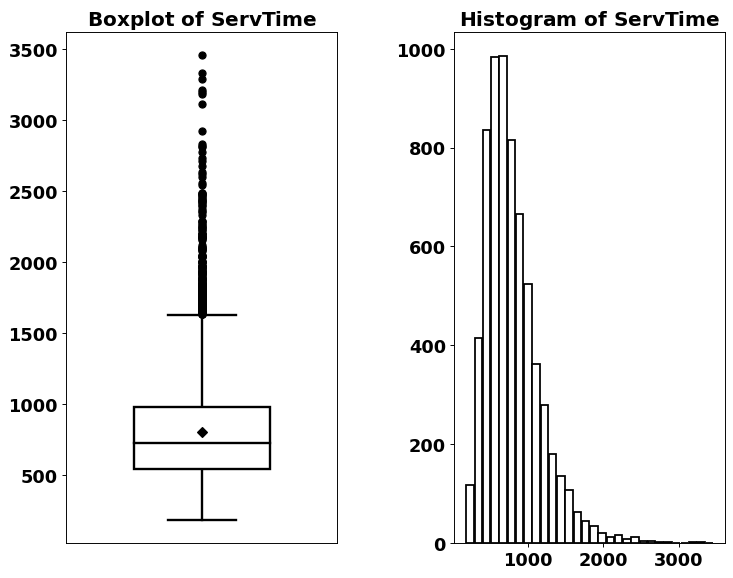

In [492]:
fig = plt.figure(figsize=(10,8),dpi = 85)
plt.subplot(121)
plt.boxplot(Data['ServTime'],vert=True,patch_artist=True,showmeans=True,widths=0.5,
           boxprops = {'color':'black','facecolor':'white','linewidth':2},
           flierprops = {'marker':'o','markerfacecolor':'black','color':'black'},
            meanprops = {'marker':'D','markerfacecolor':'black','markeredgecolor':'black'},
           medianprops = {'color':'black','linewidth':2},
           whiskerprops = {'linewidth':2},
           capprops= {'linewidth':2}
           )
plt.xticks([])
plt.title(r'$\bf{Boxplot \ of \ ServTime}$',fontsize = 17)
plt.yticks(fontweight='bold',fontsize = 15)

plt.subplot(122)
plt.hist(Data['ServTime'],bins = 30,rwidth=0.9,color = 'white',edgecolor='black',linewidth = 1.5)
plt.title(r'$\bf{Histogram\ of\ ServTime}$',fontsize = 17)
plt.yticks(fontweight='bold',fontsize = 15)
plt.xticks(fontweight='bold',fontsize = 15)
fig.tight_layout(pad=5.0)

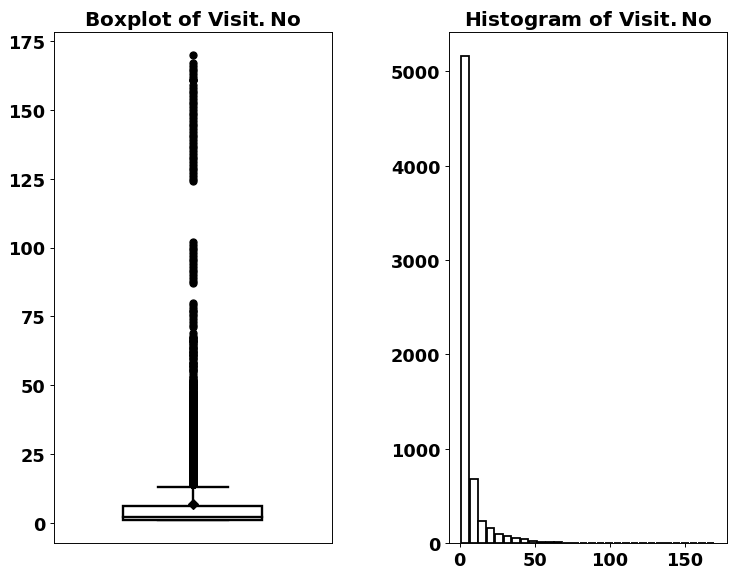

In [493]:
fig = plt.figure(figsize=(10,8),dpi = 85)
plt.subplot(121)
plt.boxplot(Data['Visit.No'],vert=True,patch_artist=True,showmeans=True,widths=0.5,notch = False,
           boxprops = {'color':'black','facecolor':'white','linewidth':2},
           flierprops = {'marker':'o','markerfacecolor':'black','color':'black'},
            meanprops = {'marker':'D','markerfacecolor':'black','markeredgecolor':'black'},
           medianprops = {'color':'black','linewidth':2},
           whiskerprops = {'linewidth':2},
           capprops= {'linewidth':2})
plt.xticks([])
plt.title(r'$\bf{Boxplot \ of \ Visit.No}$',fontsize = 17)
plt.yticks(fontweight='bold',fontsize = 15)

plt.subplot(122)
plt.hist(Data['Visit.No'],bins = 30,rwidth=0.9,color = 'white',edgecolor='black',linewidth = 1.5)
plt.title(r'$\bf{Histogram\ of\ Visit.No}$',fontsize = 17)
plt.yticks(fontweight='bold',fontsize = 15)
plt.xticks(fontweight='bold',fontsize = 15)
fig.tight_layout(pad=5.0)

In [494]:
#set parameters 
DPI = 85
FONTSIZE1 = 15
FONTSIZE2 = 13

PROPS = {
    'flierprops':{'marker':'o','markerfacecolor':'black','markeredgecolor':'black'},
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops' : {'color':'black'},
    'meanprops' :{'marker':'D','markerfacecolor':'black','markeredgecolor':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
COLOR1 = [149/255,150/255,201/255]
COLOR2 = [111/255,186/255,198/255]
COLOR3 = [211/255,144/255,162/255]
COLOR4 = [241/255,173/255,111/255]



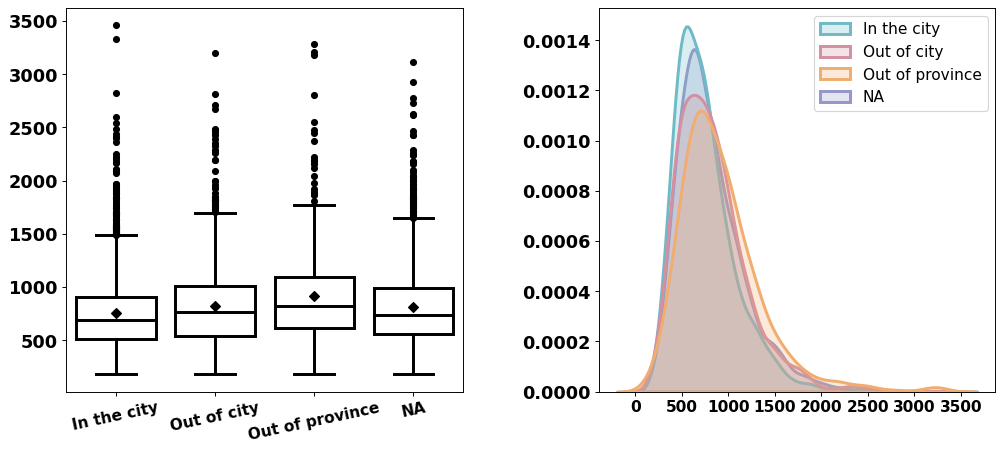

In [495]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)

plt.subplot(121)
ax1 = sns.boxplot(x = 'Address',y = Data['ServTime'],data = Data,order=['In the city','Out of city', 'Out of province','NA'],notch =False,showmeans=True,
                 linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2,rotation = 12)


plt.subplot(122)
sns.kdeplot(Data[Data['Address']=='NA']['ServTime'],fill=True,label = 'NA',linewidth=2.5,color = COLOR1)
sns.kdeplot(Data[Data['Address']=='In the city']['ServTime'],fill=True,label = 'In the city',linewidth=2.5,color =  COLOR2)
sns.kdeplot(Data[Data['Address']=='Out of city']['ServTime'],fill=True,label = 'Out of city',linewidth=2.5,color = COLOR3)
sns.kdeplot(Data[Data['Address']=='Out of province']['ServTime'],fill=True,label = 'Out of province',linewidth=2.5,color = COLOR4)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = 13)
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')

fig.tight_layout()
fig.tight_layout(pad=5.0)

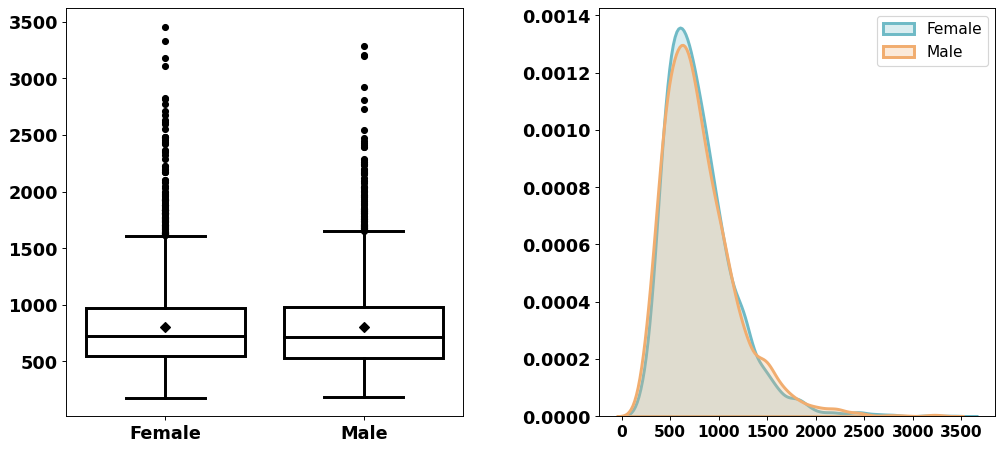

In [496]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)


plt.subplot(121)
sns.boxplot(x = 'Gender',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['Female', 'Male'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)


plt.subplot(122)
sns.kdeplot(Data[Data['Gender']=='F']['ServTime'],fill=True,label = 'Female',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['Gender']=='M']['ServTime'],fill=True,label = 'Male',linewidth=2.5,color = COLOR4)

plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)

fig.tight_layout()
fig.tight_layout(pad=5.0)

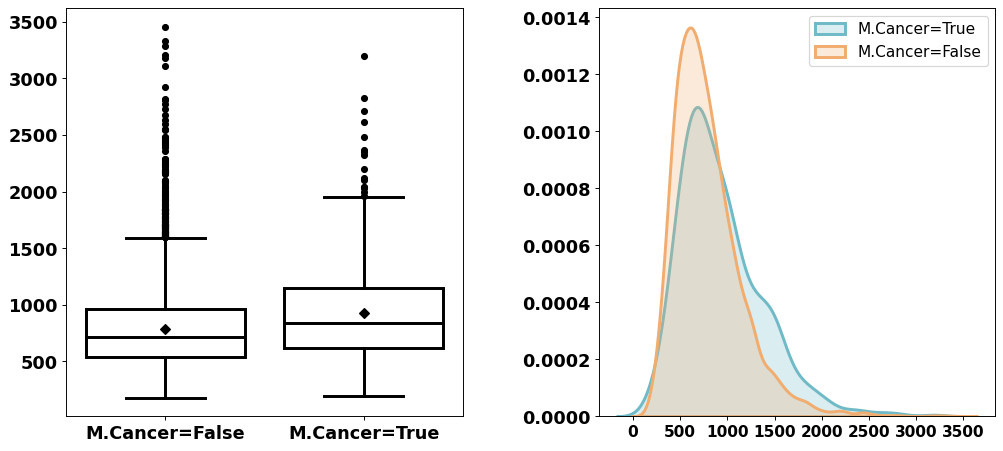

In [497]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)

plt.subplot(121)
sns.boxplot(x = 'M.Cancer',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
                linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['M.Cancer=False', 'M.Cancer=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)


plt.subplot(122)
sns.kdeplot(Data[Data['M.Cancer']==True]['ServTime'],fill=True,label = 'M.Cancer=True',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['M.Cancer']==False]['ServTime'],fill=True,label = 'M.Cancer=False',linewidth=2.5,color = COLOR4)
plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)


fig.tight_layout()
fig.tight_layout(pad=5.0)

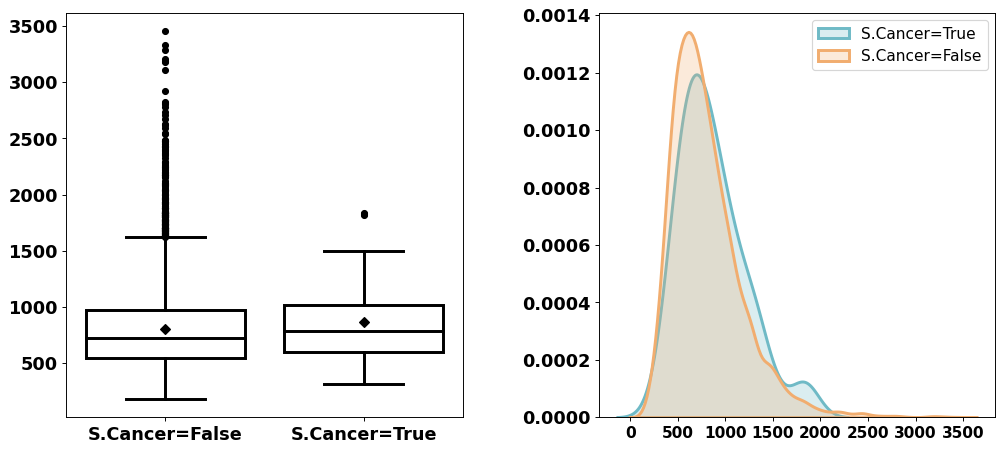

In [498]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)


plt.subplot(121)
sns.boxplot(x = 'S.Cancer',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
                linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['S.Cancer=False', 'S.Cancer=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)


plt.subplot(122)
sns.kdeplot(Data[Data['S.Cancer']==True]['ServTime'],fill=True,label = 'S.Cancer=True',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['S.Cancer']==False]['ServTime'],fill=True,label = 'S.Cancer=False',linewidth=2.5,color = COLOR4)

plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)


fig.tight_layout()
fig.tight_layout(pad=5.0)

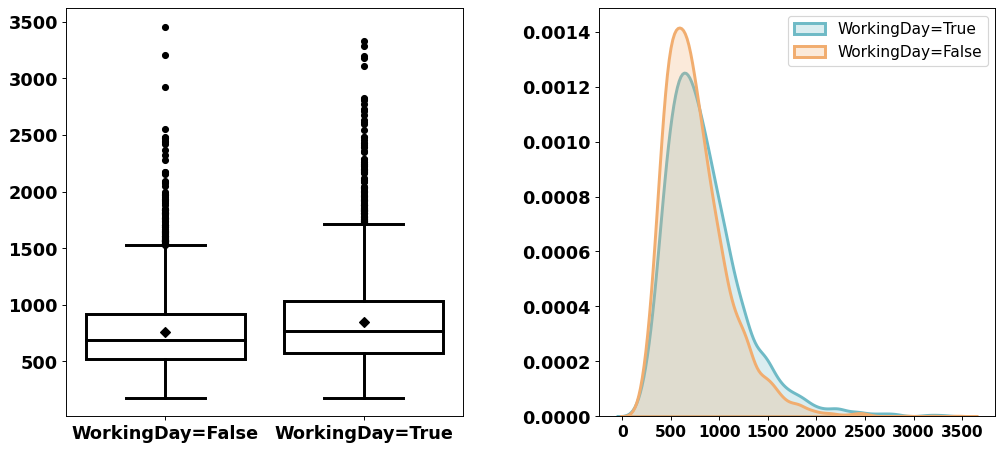

In [499]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)


plt.subplot(121)
sns.boxplot(x = 'WorkingDay',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
                linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['WorkingDay=False', 'WorkingDay=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)


plt.subplot(122)
sns.kdeplot(Data[Data['WorkingDay']==True]['ServTime'],fill=True,label = 'WorkingDay=True',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['WorkingDay']==False]['ServTime'],fill=True,label = 'WorkingDay=False',linewidth=2.5,color = COLOR4)

plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)


fig.tight_layout()
fig.tight_layout(pad=5.0)

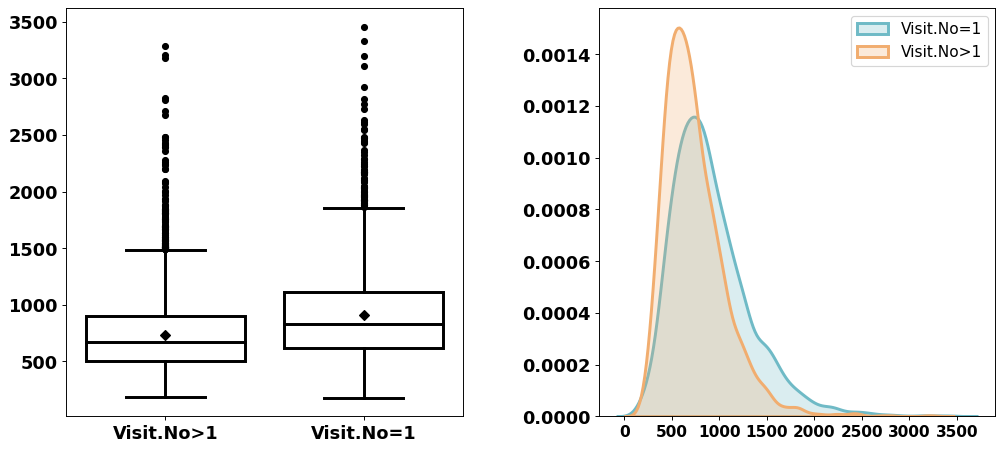

In [500]:
Data['FirstVisit'] = Data['Visit.No'].apply(lambda x: True if x==1 else False)
fig = plt.figure(figsize = (13,6.5),dpi = DPI)

plt.subplot(121)
sns.boxplot(x = 'FirstVisit',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['Visit.No>1', 'Visit.No=1'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(122)
sns.kdeplot(Data[Data['FirstVisit']==True]['ServTime'],fill=True,label = 'Visit.No=1',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['FirstVisit']==False]['ServTime'],fill=True,label = 'Visit.No>1',linewidth=2.5,color = COLOR4)
plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)

fig.tight_layout()
fig.tight_layout(pad=5.0)

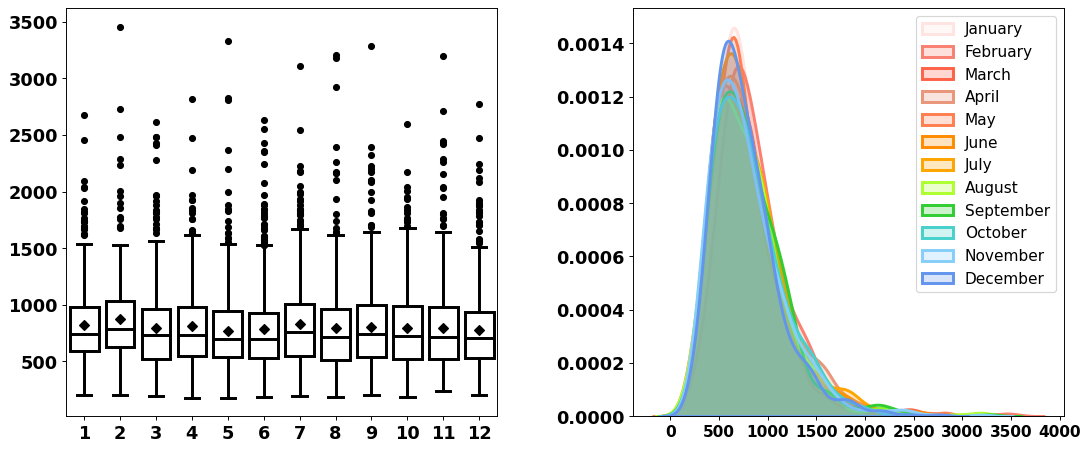

In [501]:
fig = plt.figure(figsize = (14,6.5),dpi = DPI)


plt.subplot(121)
sns.boxplot(x = 'Month',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(12), range(1,13))
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(122)
colors = ['mistyrose','salmon','tomato','darksalmon','coral','darkorange','orange','greenyellow','limegreen','mediumturquoise','lightskyblue','cornflowerblue']
for i,j in zip(Data['Month'].unique(),colors):
    sns.kdeplot(Data[Data['Month']==i]['ServTime'],fill=True,label = i,linewidth=2.5,color =j)
plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)
fig.tight_layout()
fig.tight_layout(pad=5.0)

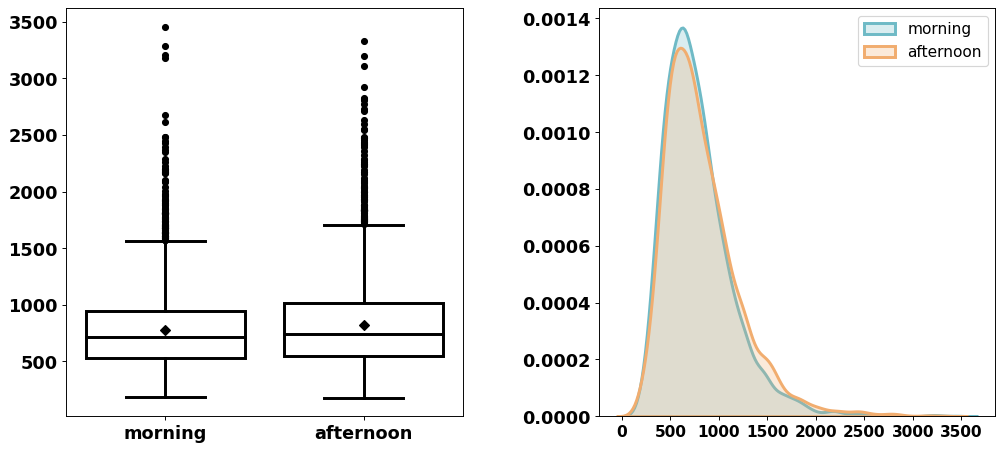

In [502]:
fig = plt.figure(figsize = (13,6.5),dpi = DPI)


plt.subplot(121)
sns.boxplot(x = 'AM_PM',y = Data['ServTime'],data = Data,notch = False,showmeans=True,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)


plt.subplot(122)
sns.kdeplot(Data[Data['AM_PM']=='morning']['ServTime'],fill=True,label = 'morning',linewidth=2.5,color = COLOR2)
sns.kdeplot(Data[Data['AM_PM']=='afternoon']['ServTime'],fill=True,label = 'afternoon',linewidth=2.5,color = COLOR4)

plt.legend(loc='best',fontsize = FONTSIZE2)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE2)


fig.tight_layout()
fig.tight_layout(pad=5.0)

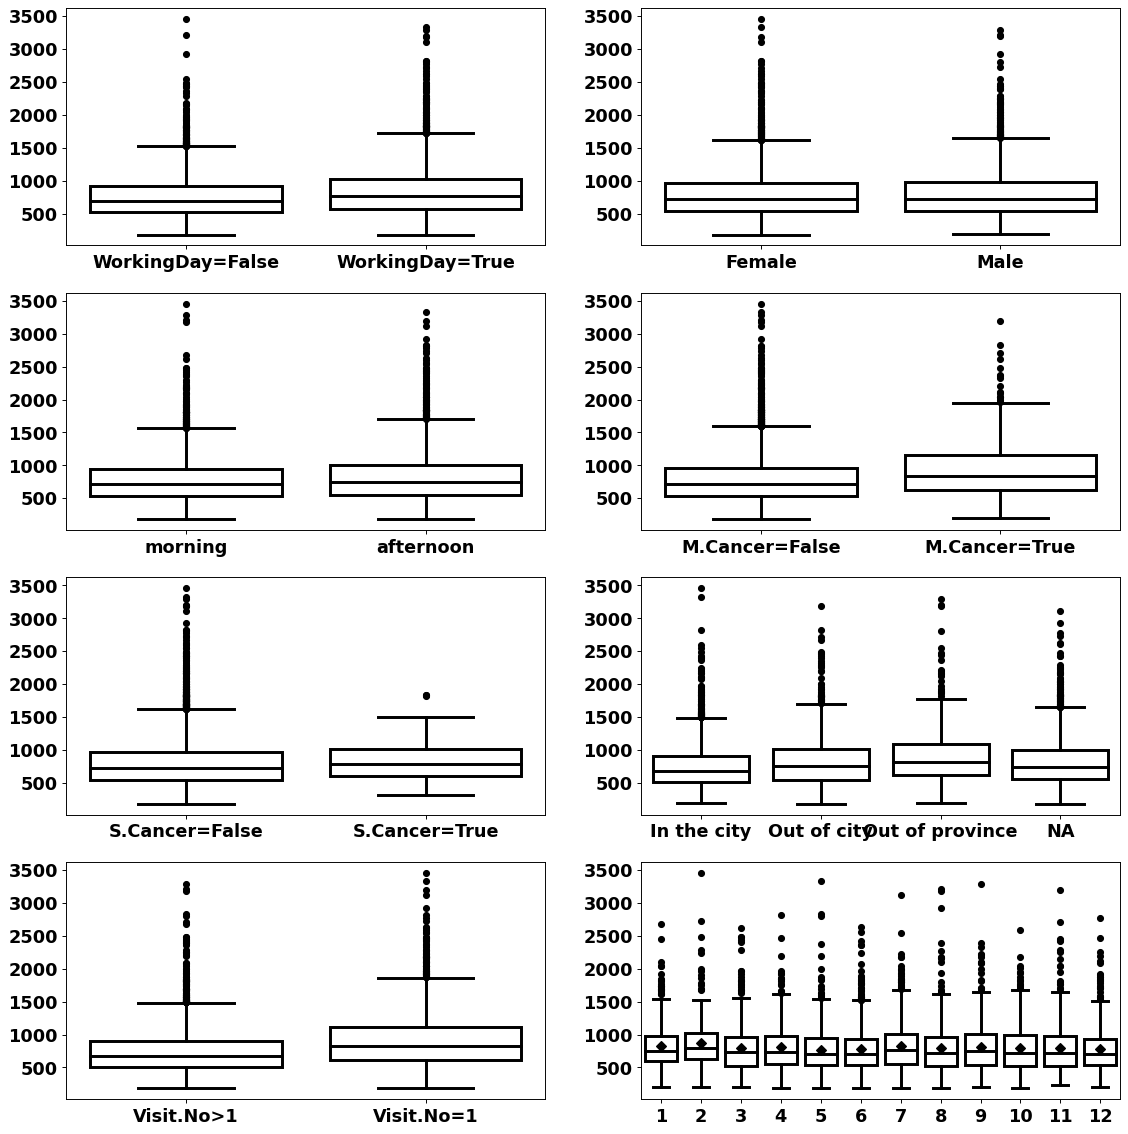

In [503]:
fig =plt.figure(figsize = (16,17),dpi = DPI)

plt.subplot(421)
sns.boxplot(x = 'WorkingDay',y = Data['ServTime'],data = Data,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['WorkingDay=False', 'WorkingDay=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(422)
sns.boxplot(x = 'Gender',y = Data['ServTime'],data = Data,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['Female', 'Male'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(423)
sns.boxplot(x = 'AM_PM',y = Data['ServTime'],data = Data,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(424)
sns.boxplot(x = 'M.Cancer',y = Data['ServTime'],data = Data,
                linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['M.Cancer=False', 'M.Cancer=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(425)
sns.boxplot(x = 'S.Cancer',y = Data['ServTime'],data = Data,
                linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['S.Cancer=False', 'S.Cancer=True'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(426)
ax1 = sns.boxplot(x = 'Address',y = Data['ServTime'],data = Data,order=['In the city',"Out of city", 'Out of province','NA'],
                 linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(427)
sns.boxplot(x = 'FirstVisit',y = Data['ServTime'],data = Data,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0,1], ['Visit.No>1', 'Visit.No=1'])
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

plt.subplot(428)
sns.boxplot(x = 'Month',y = Data['ServTime'],data = Data,showmeans=True,
            linewidth=2.5,color = 'white',**PROPS)
plt.tick_params(axis='both')
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(12), range(1,13))
plt.yticks(fontweight='bold',fontsize = FONTSIZE1)
plt.xticks(fontweight='bold',fontsize = FONTSIZE1)

In [504]:
print(Data.pivot_table(index = ['WorkingDay'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['Gender'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['AM_PM'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['M.Cancer'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['S.Cancer'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['Address'],columns= ['FirstVisit'],values='ServTime',aggfunc={'mean','median'}))

                  mean             median       
FirstVisit       False        True  False   True
WorkingDay                                      
False       698.034288  858.841100  642.0  799.0
True        777.484515  965.263993  715.0  883.0
                  mean             median       
FirstVisit       False        True  False   True
Gender                                          
F           735.968013  915.427184  673.0  837.0
M           737.412883  901.877820  672.0  820.5
                  mean             median       
FirstVisit       False        True  False   True
AM_PM                                           
afternoon   752.955710  924.756134  680.0  840.0
morning     722.906513  892.202412  667.0  821.0
                  mean              median        
FirstVisit       False         True  False    True
M.Cancer                                          
False       726.489356   885.411815  661.0   816.0
True        815.379015  1282.810458  749.0  1282.0
          

In [505]:
print(Data.pivot_table(index = ['WorkingDay'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['Gender'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['AM_PM'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['M.Cancer'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['S.Cancer'],values='ServTime',aggfunc={'mean','median'}))
print(Data.pivot_table(index = ['Address'],values='ServTime',aggfunc={'mean','median'}))

                  mean  median
WorkingDay                    
False       759.260617   691.0
True        847.747734   767.0
              mean  median
Gender                    
F       801.598275   727.0
M       802.368597   720.0
                 mean  median
AM_PM                        
afternoon  824.739360   739.0
morning    780.411644   717.0
                mean  median
M.Cancer                    
False     788.637361   719.0
True      930.729032   839.0
                mean  median
S.Cancer                    
False     801.275495   724.0
True      864.223881   788.0
                       mean  median
Address                            
In the city      752.753490   686.5
NA               813.048913   733.0
Out of city      822.374915   762.0
Out of province  917.150206   821.0


### corralation coefficient

In [506]:
Data2 = Data.copy()
#code categorical variable
Data2['AM_PM'] = Data2['AM_PM'].map({'morning':False,'afternoon':True})
Data2['Gender'] = Data2['Gender'].map({'F':False,'M':True})
Data2['Month'] = Data2['Month'].map(dict(zip(Data2['Month'].unique(),[i for i in range(1,13)])))
Data2['DayOfWeek'] = Data2['DayOfWeek'].map(dict(zip(Data2['DayOfWeek'].unique(),[i for i in range(1,5)])))
Data2['Address'] = Data2['Address'].map(dict(zip(Data2['Address'].unique(),[i for i in range(1,5)])))


(-0.059529430684335596, 1.2153319980653374e-06)


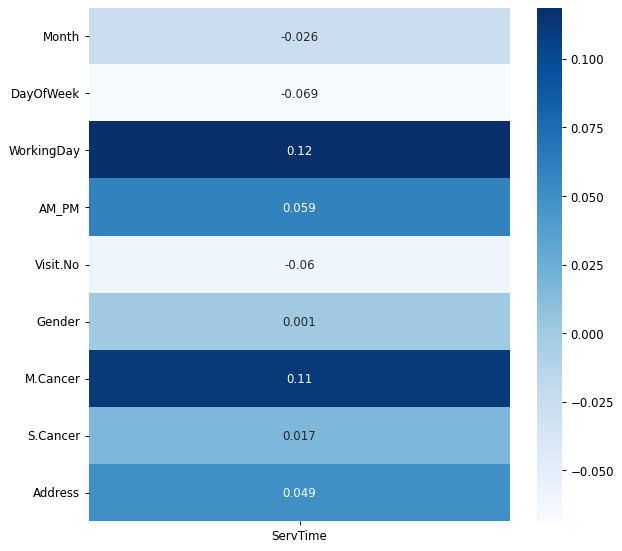

In [507]:
# compute corralation coefficient
corr = Data2.drop(columns='Session').corr()

#calculation correlation coefficient and p-value between x and y
print(pearsonr(Data2['Visit.No'],Data2['ServTime']))

df = pd.DataFrame(corr.loc[:'Address','ServTime'],
              index=corr.loc[:'Address','ServTime'].index)
fig =plt.figure(figsize = (8,8),dpi = 85)
sns.heatmap(df, annot=True,cmap="Blues")
plt.savefig('/Users/zhousiyi/Desktop/pic/heatmap.pdf')




### linear regression

In [508]:
Data3 = Data.copy()
Data3 = Data3.drop(columns = ['StartTime','PayTime','ID','Session','FirstVisit'])
Data3 = pd.get_dummies(Data3,columns = ['Gender','Month','DayOfWeek','Address','AM_PM'], drop_first=True) 

In [509]:
#linear regression
x = Data3.drop(columns = ['ServTime'])
y = Data3['ServTime']
x_ = sm.add_constant(x)
model = sm.OLS(y.astype(float),x_.astype(float))
results = model.fit()
print(results.rsquared)
print(results.summary())

0.04856384560577032
                            OLS Regression Results                            
Dep. Variable:               ServTime   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     14.68
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           4.29e-56
Time:                        16:45:36   Log-Likelihood:                -48552.
No. Observations:                6637   AIC:                         9.715e+04
Df Residuals:                    6613   BIC:                         9.731e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

/Users/zhousiyi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
